# Stock analysis

## Import

Libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import defaultdict as dd

import yfinance as yf

Definitions

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
index_tickers = ['^AXJO', '^AXKO', '^AXSO', '^AORD']
# Proxy for 200, 300, small ord, all ords

## Get data

Define Functions

In [4]:
def get_prices(ticker: str, start_date: str, end_date: str = None, interval: str = '1d') -> pd.DataFrame:
    """ 
    Get historical prices for a given ticker.

    Parameters:
        - ticker (str): The ticker symbol of the stock.
        - start (str): The start date of the historical prices.
        - end_str (str): (default=None) The end date of the historical prices.
        - interval (str): (default='1d') The interval of the historical prices.
    """

    price_df_list = []

    if end_date is None:
        end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    # get prices for each year and concat to get the full price_df
    for year in range(start_year, end_year + 1):
        if year == start_year:
            price_df = yf.Ticker(ticker).history(
                interval=interval, start=start_date, end=f'{year}-12-31')
        elif year == end_year:
            price_df = yf.Ticker(ticker).history(
                interval=interval, start=f'{year}-01-01', end=end_date)
        else:
            price_df = yf.Ticker(ticker).history(
                interval=interval, start=f'{year}-01-01', end=f'{year}-12-31')

        price_df_list.append(price_df)

    price_df = pd.concat(price_df_list)

    try:
        price_df['Dividends'] = price_df['Dividends'].astype(float)
    except:
        pass

    return price_df

In [5]:
def get_return(price_df: pd.DataFrame, interval: str = 'M') -> pd.DataFrame:
    """ 
    Get return of stock on a monthly basis (last close price/last close price previous period - 1)

        - pride_df: pd.DataFrame
        - interval: str (default='M')
    """
    assert interval in ['M', 'Q', 'Y'], 'interval must be M, Q or Y'

    # find the last close price of each period
    last_close_price = price_df.resample(interval).last()

    # calculate the return
    return_series = last_close_price['Close'].pct_change()*100

    # turn into a dataframe
    return_series = return_series.to_frame()

    return_series.columns = [f'{interval}_Return (%)']
    # set index to month
    return_series.index = return_series.index.strftime('%Y-%m')

    return return_series

In [6]:
def get_stats(monthly_returns_df_dict: str, ticker: str, start_period: str, end_year: str):

    period_of_interest_return_df = monthly_returns_df_dict[ticker].loc[start_period:end_year]

    stats_dict = {}

    # mean, std, n
    stats_dict['mean (%)'] = np.round(
        period_of_interest_return_df.mean().values[0], 2)
    stats_dict['std (%)'] = np.round(
        period_of_interest_return_df.std().values[0], 2)
    stats_dict['n'] = period_of_interest_return_df.shape[0]

    # sharpe
    mode = monthly_returns_df_dict[ticker].columns[0].split('_')[0]
    sharpe_multiplier = 4 if mode == 'Q' else 12 if mode == 'M' else 1
    stats_dict['sharpe'] = np.round(np.sqrt(
        sharpe_multiplier) * stats_dict['mean (%)'] / stats_dict['std (%)'], 2)

    # earliest and latest date for ticker
    regression_start_period = monthly_returns_df_dict[ticker].index[1]
    regression_end_period = monthly_returns_df_dict[ticker].index[-1]

    # beta over this period
    X = monthly_returns_df_dict['^AORD'].loc[regression_start_period:
                                             regression_end_period][f'{mode}_Return (%)']
    X = sm.add_constant(X)
    y = monthly_returns_df_dict[ticker].loc[regression_start_period:
                                            regression_end_period][f'{mode}_Return (%)']

    linreg = sm.OLS(y, X).fit()
    stats_dict['CAPM beta'] = np.round(linreg.params[f'{mode}_Return (%)'], 2)
    stats_dict['CAPM alpha'] = np.round(linreg.params['const'], 2)

    return stats_dict

In [7]:
def historical_corr(monthly_returns_df_dict: dict, start_period: str, end_year: str):
    """
    Get the historical correlation between two stocks.

    Parameters:
        - historical_returns: dict
        - start_period: str
        - end_year: str
    """

    period_of_interest_return_df = pd.DataFrame()

    for ticker, returns_df in monthly_returns_df_dict.items():
        returns_df = returns_df.loc[start_period:end_year]
        returns_df.rename(
            columns={returns_df.columns[0]: ticker}, inplace=True)

        period_of_interest_return_df = pd.merge(
            period_of_interest_return_df, returns_df, left_index=True, right_index=True, how='outer')

    # calculate correlation: corr() function from pandas
    correlation_df = period_of_interest_return_df.corr()  # TODO

    return correlation_df, period_of_interest_return_df

In [8]:
def plot_returns(monthly_returns_df_dict: dict, quarterly_returns_df_dict: dict, yearly_returns_df_dict: dict, TICKER: str, first_end_of_quarter: str, last_end_of_quarter: str, **kwargs):

    # Create a figure and 3 subplots
    fig, axs = plt.subplots(3, 1, figsize=(8, 8))

    interested_monthly_returns_df = monthly_returns_df_dict[TICKER][
        monthly_returns_df_dict[TICKER].index > first_end_of_quarter]
    interested_quarterly_returns_df = quarterly_returns_df_dict[TICKER][
        quarterly_returns_df_dict[TICKER].index > first_end_of_quarter]
    interested_yearly_returns_df = yearly_returns_df_dict[TICKER][
        yearly_returns_df_dict[TICKER].index > first_end_of_quarter]

    # Plot monthly returns as a bar chart
    axs[0].bar(interested_monthly_returns_df.index, interested_monthly_returns_df.values.flatten(
    ), label='Monthly Returns (%)', color='red')
    axs[0].axhline(y=0, color='gray', lw=1, linestyle=':', linewidth=0.5)
    axs[0].set_title('Monthly Returns (%)')
    axs[0].set_ylabel('Returns (%)')
    axs[0].set_xticks(np.arange(0, len(interested_monthly_returns_df), 3))
    axs[0].tick_params(axis='x', rotation=90)

    # Plot quarterly returns as a bar chart
    axs[1].bar(interested_quarterly_returns_df.index, interested_quarterly_returns_df.values.flatten(
    ), label='Quarterly Returns (%)', color='orange')
    axs[1].axhline(y=0, color='gray', lw=1, linestyle=':', linewidth=0.5)
    axs[1].set_title('Quarterly Returns (%)')
    axs[1].set_ylabel('Returns (%)')
    axs[1].tick_params(axis='x', rotation=90)  # Rotate x-axis tick labels

    # Add text above the bars for quarterly returns
    for i, value in enumerate(interested_quarterly_returns_df.values.flatten()):
        axs[1].text(i, value, f'{value:.1f}%', ha='center',
                    va='bottom', fontsize=8, rotation=45)

    # Plot yearly returns as a bar chart
    axs[2].bar(interested_yearly_returns_df.index, interested_yearly_returns_df.values.flatten(
    ), label='Yearly Returns (%)', color='yellow')
    axs[2].axhline(y=0, color='gray', lw=1, linestyle=':', linewidth=0.5)
    axs[2].set_title('Yearly Returns (%)')
    axs[2].set_ylabel('Returns (%)')
    axs[2].tick_params(axis='x', rotation=90)  # Rotate x-axis tick labels

    # Add text above the bars for quarterly returns
    for i, value in enumerate(interested_yearly_returns_df.values.flatten()):
        axs[2].text(i, value, f'{value:.1f}%', ha='center',
                    va='bottom', fontsize=8, rotation=45)

    # Set x-label only on the last subplot
    axs[2].set_xlabel('Date')

    fig.suptitle(
        f'{TICKER} Returns from {first_end_of_quarter} to {last_end_of_quarter}', fontsize=16)

    # Rotate x-axis labels 90 degrees on the last subplot
    plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=90)

    # Tight layout for better spacing between plots
    plt.tight_layout()

    # Show the plot
    plt.show()

In [42]:
def plot_correlation(correlation_df: pd.DataFrame):
    """
    Plot the correlation matrix.

    Parameters:
        - correlation_df: pd.DataFrame
    """
    plt.figure(figsize=(10, 8))
    # Set vmin and vmax to -1 and 1, respectively, and use the custom colormap
    plt.matshow(correlation_df, fignum=1, vmin=-1, vmax=1, cmap="RdBu")
    plt.xticks(range(len(correlation_df.columns)),
               correlation_df.columns, rotation=75)
    plt.yticks(range(len(correlation_df.columns)), correlation_df.columns)
    # Colour bar with the custom colormap
    plt.colorbar()
    plt.title(f'{TICKER} Monthly Return Correlation Matrix')
    plt.show()

Run data

In [163]:
TICKER = 'TWE'
first_end_of_quarter = '2020-06'
last_end_of_quarter = '2024-06'

In [164]:
asx_companies_directory = pd.read_csv('../data/asx_companies_directory.csv')
gics = pd.read_csv('../data/asx_gics.csv')

gics['Industry'] = gics['Industry'].apply(lambda x: ''.join(
    str(x).split('-')).replace(' ', '').replace('—', ''))

asx_companies_directory['Market Cap'] = asx_companies_directory['Market Cap'].apply(
    lambda x: float(x) if x.isnumeric() else float(x.lower()) if 'E+' in x else np.nan)

In [165]:
top_500 = asx_companies_directory.sort_values(
    'Market Cap', ascending=False).head(500)['ASX code'].values + '.AX'

In [166]:
above_1b = asx_companies_directory[asx_companies_directory['Market Cap']
                                   >= 1000000000]['ASX code'].values + '.AX'

In [167]:
# find same industry stocks
ticker_gics_sector = gics[gics['Ticker'] == f'{TICKER}.AX']['Sector'].values[0]
ticker_gics_industry = gics[gics['Ticker']
                            == f'{TICKER}.AX']['Industry'].values[0]

same_sector_tickers = gics[(gics['Sector'] == ticker_gics_sector) & (
    gics['Ticker'].isin(top_500))]['Ticker'].values
same_industry_tickers = gics[(gics['Industry'] == ticker_gics_industry) & (
    gics['Ticker'].isin(top_500))]['Ticker'].values

In [168]:
ticker_gics_sector

'Consumer Defensive'

In [170]:
ticker_gics_industry

'BeveragesWineries&Distilleries'

In [171]:
# get market caps and weight
same_industry_tickers_mcap = asx_companies_directory[((asx_companies_directory['ASX code']+'.AX').isin(
    same_industry_tickers)) & (asx_companies_directory['ASX code'] != TICKER)][['ASX code', 'Market Cap']]
# check for is integer
marketsame_industry_tickers_mcap_cap = same_industry_tickers_mcap[same_industry_tickers_mcap['Market Cap'].apply(
    lambda x: isinstance(x, float))]

In [172]:
same_industry_tickers_mcap['weight'] = same_industry_tickers_mcap['Market Cap'] / \
    same_industry_tickers_mcap['Market Cap'].sum()

In [173]:
same_industry_tickers_mcap = same_industry_tickers_mcap.sort_values(
    by='Market Cap', ascending=False)
display(same_industry_tickers_mcap)

ticker_mv = asx_companies_directory[asx_companies_directory['ASX code'] == TICKER][[
    'ASX code', 'Market Cap']]
display(ticker_mv)

ticker_proportion_of_market = ticker_mv['Market Cap'].values[0] / \
    same_industry_tickers_mcap['Market Cap'].sum()
print(ticker_proportion_of_market)

,ASX code,Market Cap,weight
606,EDV,8.847441e+09,1.0


,ASX code,Market Cap
1796,TWE,9.777689e+09


1.1051430970988516


In [174]:
same_gics_industry_weight_dict = same_industry_tickers_mcap.set_index('ASX code')[
    'weight'].to_dict()

In [175]:
my_portfolio_tickers = [TICKER]
my_portfolio_tickers.extend([ticker.split(
    '.')[0] for ticker in same_industry_tickers if ticker.split('.')[0] != TICKER])


my_portfolio_tickers.extend(index_tickers)

historical_prices = {}

for ticker in my_portfolio_tickers:
    print(ticker)
    historical_prices[ticker] = get_prices(
        f'{ticker}.AX' if ticker not in index_tickers else ticker, '2019-06-01')

TWE
EDV


$EDV.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$EDV.AX: possibly delisted; no price data found  (1d 2020-01-01 -> 2020-12-31) (Yahoo error = "Data doesn't exist for startDate = 1577797200, endDate = 1609333200")


^AXJO
^AXKO
^AXSO
^AORD


In [176]:
monthly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    monthly_returns_df_dict[ticker] = get_return(price_df, 'M')

quarterly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    quarterly_returns_df_dict[ticker] = get_return(price_df, 'Q')

yearly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    yearly_returns_df_dict[ticker] = get_return(price_df, 'Y')

In [177]:
def get_gics_industry_weighted_mean(return_df_dict: dict, TICKER: str, my_portfolio_tickers: list, same_gics_industry_weight_dict: dict, index_tickers: list, mode: str, **kwargs) -> pd.DataFrame:

    GICS_Industry_Weighted_Mean = dd(float)

    # Iterate through each ticker in the portfolio
    for ticker in my_portfolio_tickers:
        # Skip the index tickers and the main TICKER
        if ticker not in index_tickers + [TICKER]:
            # Iterate through the dates of the return data for the ticker
            for date in return_df_dict[ticker].index:
                # Check if the return value is not NaN

                if not pd.isna(return_df_dict[ticker].loc[date].values[0]):
                    # Sum the weighted returns for the GICS industry by date
                    GICS_Industry_Weighted_Mean[date] += same_gics_industry_weight_dict[ticker] * \
                        return_df_dict[ticker].loc[date].values[0]

    # Create a DataFrame to store the results
    weighted_mean_df = pd.DataFrame.from_dict(
        GICS_Industry_Weighted_Mean, orient='index', columns=[f'{mode}_Return (%)'])
    return_df_dict['GICS Industry Weighted Mean'] = weighted_mean_df

    return return_df_dict

In [178]:
monthly_returns_df_dict = get_gics_industry_weighted_mean(
    monthly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'M')
quarterly_returns_df_dict = get_gics_industry_weighted_mean(
    quarterly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'Q')
yearly_returns_df_dict = get_gics_industry_weighted_mean(
    yearly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'Y')

In [179]:
stats_dict = {}

for ticker in monthly_returns_df_dict:
    stats_dict[ticker] = get_stats(
        monthly_returns_df_dict, ticker, first_end_of_quarter, last_end_of_quarter)

stats_df = pd.DataFrame(stats_dict).T
stats_df

,mean (%),std (%),n,sharpe,CAPM beta,CAPM alpha
TWE,1.00,7.17,49.0,0.48,0.45,-0.03
EDV,-0.17,5.73,37.0,-0.10,0.57,-0.37
^AXJO,0.69,3.84,49.0,0.62,0.98,-0.03
^AXKO,0.68,3.87,49.0,0.61,0.98,-0.03
^AXSO,0.35,5.03,49.0,0.24,1.18,-0.24
^AORD,0.71,3.92,49.0,0.63,1.00,0.00
GICS Industry Weighted Mean,-0.17,5.73,36.0,-0.10,0.56,-0.50


In [180]:
# get rows where index are not index tickers or iel
same_gics_stats_df = stats_df[~stats_df.index.isin(
    index_tickers + [TICKER, 'Gics Industry Weighted Mean'])]

In [181]:
same_gics_stats_df['ASX code'] = same_gics_stats_df.index

same_gics_stats_df = same_gics_stats_df.merge(
    same_industry_tickers_mcap, on='ASX code')

In [182]:
# get weighted means of each column
weighted_mean_dict = {}
for col in same_gics_stats_df.columns:
    if col in ['ASX code', 'weight']:
        continue
    weighted_mean_dict[col] = np.average(
        same_gics_stats_df[col], weights=same_gics_stats_df['weight'])

weighted_mean_df = pd.DataFrame(weighted_mean_dict, index=[
                                'GICS Industry Weighted Mean (Macro)'])
weighted_mean_df

stats_df = pd.concat([stats_df, weighted_mean_df.drop(columns=['Market Cap'])])
stats_df

,mean (%),std (%),n,sharpe,CAPM beta,CAPM alpha
TWE,1.00,7.17,49.0,0.48,0.45,-0.03
EDV,-0.17,5.73,37.0,-0.10,0.57,-0.37
^AXJO,0.69,3.84,49.0,0.62,0.98,-0.03
^AXKO,0.68,3.87,49.0,0.61,0.98,-0.03
^AXSO,0.35,5.03,49.0,0.24,1.18,-0.24
^AORD,0.71,3.92,49.0,0.63,1.00,0.00
GICS Industry Weighted Mean,-0.17,5.73,36.0,-0.10,0.56,-0.50
GICS Industry Weighted Mean (Macro),-0.17,5.73,37.0,-0.10,0.57,-0.37


In [183]:
ticker_mv['Market Cap'].values[0]/weighted_mean_df['Market Cap'].values[0]

1.1051430970988516

In [184]:
correlation_df, period_of_interest_return_df = historical_corr(
    monthly_returns_df_dict, first_end_of_quarter, last_end_of_quarter)

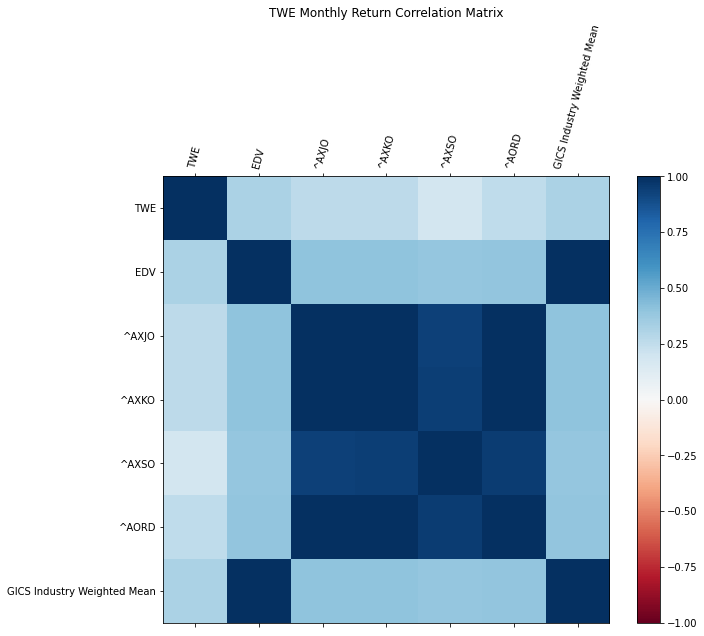

In [185]:
plot_correlation(correlation_df)

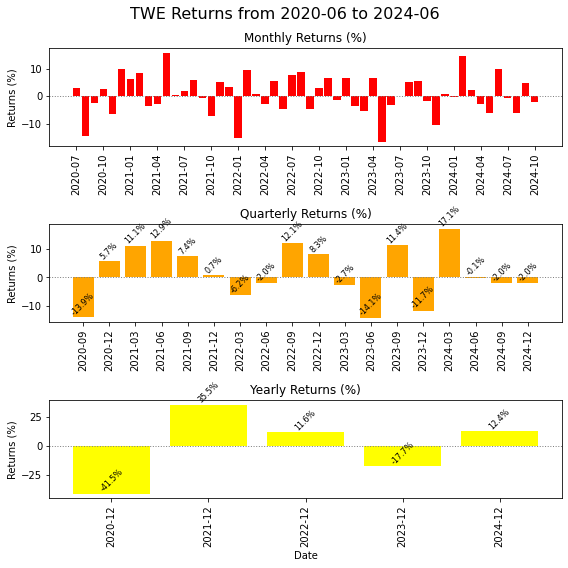

In [186]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': TICKER,
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

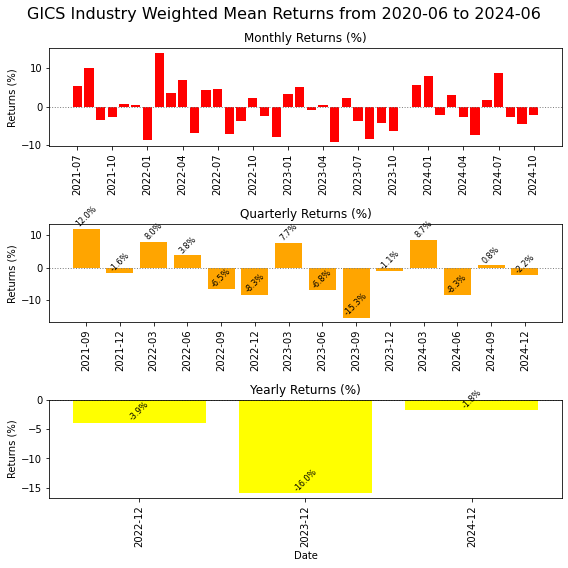

In [187]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': 'GICS Industry Weighted Mean',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

In [188]:
def plot_returns_comparative(monthly_returns_df_dict: dict, quarterly_returns_df_dict: dict, yearly_returns_df_dict: dict,
                             TICKER: str,
                             first_end_of_quarter: str, last_end_of_quarter: str, **kwargs):

    # Create a figure and 3 subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    # Filter data for the selected range
    interested_monthly_returns_df = monthly_returns_df_dict[TICKER][
        monthly_returns_df_dict[TICKER].index > first_end_of_quarter]
    interested_quarterly_returns_df = quarterly_returns_df_dict[TICKER][
        quarterly_returns_df_dict[TICKER].index > first_end_of_quarter]
    interested_yearly_returns_df = yearly_returns_df_dict[TICKER][
        yearly_returns_df_dict[TICKER].index > first_end_of_quarter]

    # Also filter for the industry weighted mean and AORD
    industry_monthly_returns = monthly_returns_df_dict['GICS Industry Weighted Mean'][
        monthly_returns_df_dict['GICS Industry Weighted Mean'].index > first_end_of_quarter]
    aord_monthly_returns = monthly_returns_df_dict['^AORD'][
        monthly_returns_df_dict['^AORD'].index > first_end_of_quarter]

    # Define bar width and offsets
    bar_width = 0.2
    x_labels = interested_monthly_returns_df.index
    x = np.arange(len(x_labels))

    # Plot monthly returns for TICKER, GICS Industry Weighted Mean, and AORD
    axs[0].bar(x - bar_width, interested_monthly_returns_df.values.flatten(),
               width=bar_width, label=f'{TICKER} Monthly Returns (%)', color='red')
    axs[0].bar(x, industry_monthly_returns.values.flatten(
    ), width=bar_width, label='GICS Industry Weighted Mean (%)', color='blue')
    axs[0].bar(x + bar_width, aord_monthly_returns.values.flatten(),
               width=bar_width, label='^AORD (%)', color='green')
    axs[0].axhline(y=0, color='gray', lw=1, linestyle=':', linewidth=0.5)
    axs[0].set_title('Monthly Returns (%)')
    axs[0].set_ylabel('Returns (%)')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(x_labels, rotation=90)
    axs[0].legend()

    # Repeat the same for quarterly returns
    industry_quarterly_returns = quarterly_returns_df_dict['GICS Industry Weighted Mean'][
        quarterly_returns_df_dict['GICS Industry Weighted Mean'].index > first_end_of_quarter]
    aord_quarterly_returns = quarterly_returns_df_dict['^AORD'][
        quarterly_returns_df_dict['^AORD'].index > first_end_of_quarter]

    x_labels_quarterly = interested_quarterly_returns_df.index
    x_quarterly = np.arange(len(x_labels_quarterly))

    axs[1].bar(x_quarterly - bar_width, interested_quarterly_returns_df.values.flatten(),
               width=bar_width, label=f'{TICKER} Quarterly Returns (%)', color='orange')
    axs[1].bar(x_quarterly, industry_quarterly_returns.values.flatten(
    ), width=bar_width, label='GICS Industry Weighted Mean (%)', color='blue')
    axs[1].bar(x_quarterly + bar_width, aord_quarterly_returns.values.flatten(),
               width=bar_width, label='^AORD (%)', color='green')
    axs[1].axhline(y=0, color='gray', lw=1, linestyle=':', linewidth=0.5)
    axs[1].set_title('Quarterly Returns (%)')
    axs[1].set_ylabel('Returns (%)')
    axs[1].set_xticks(x_quarterly)
    axs[1].set_xticklabels(x_labels_quarterly, rotation=90)
    axs[1].legend()

    # # Add text above the bars for quarterly returns
    # for i, value in enumerate(interested_quarterly_returns_df.values.flatten()):
    #     axs[1].text(i, value, f'{value:.1f}%', ha='center',
    #                 va='bottom', fontsize=8, rotation=45)

    # Repeat for yearly returns
    industry_yearly_returns = yearly_returns_df_dict['GICS Industry Weighted Mean'][
        yearly_returns_df_dict['GICS Industry Weighted Mean'].index > first_end_of_quarter]
    aord_yearly_returns = yearly_returns_df_dict['^AORD'][
        yearly_returns_df_dict['^AORD'].index > first_end_of_quarter]

    x_labels_yearly = interested_yearly_returns_df.index
    x_yearly = np.arange(len(x_labels_yearly))

    axs[2].bar(x_yearly - bar_width, interested_yearly_returns_df.values.flatten(),
               width=bar_width, label=f'{TICKER} Yearly Returns (%)', color='yellow')
    axs[2].bar(x_yearly, industry_yearly_returns.values.flatten(
    ), width=bar_width, label='GICS Industry Weighted Mean (%)', color='blue')
    axs[2].bar(x_yearly + bar_width, aord_yearly_returns.values.flatten(),
               width=bar_width, label='^AORD (%)', color='green')
    axs[2].axhline(y=0, color='gray', lw=1, linestyle=':', linewidth=0.5)
    axs[2].set_title('Yearly Returns (%)')
    axs[2].set_ylabel('Returns (%)')
    axs[2].set_xticks(x_yearly)
    axs[2].set_xticklabels(x_labels_yearly, rotation=90)
    axs[2].legend()

    # Add text above the bars for yearly returns
    # for i, value in enumerate(interested_yearly_returns_df.values.flatten()):
    #     axs[2].text(i, value, f'{value:.1f}%', ha='center',
    #                 va='bottom', fontsize=8, rotation=45)

    # Set x-label only on the last subplot
    axs[2].set_xlabel('Date')

    fig.suptitle(
        f'{TICKER} Returns from {first_end_of_quarter} to {last_end_of_quarter}', fontsize=16)

    # Tight layout for better spacing between plots
    plt.tight_layout()

    # Show the plot
    plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (52,) and arg 1 with shape (40,).

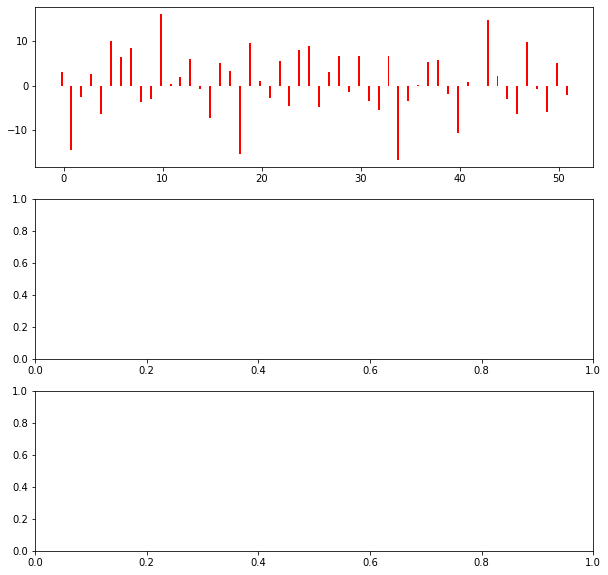

In [189]:
plot_returns_comparative(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                            'quarterly_returns_df_dict': quarterly_returns_df_dict,
                            'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': TICKER,
                            'first_end_of_quarter': first_end_of_quarter,
                            'last_end_of_quarter': last_end_of_quarter})

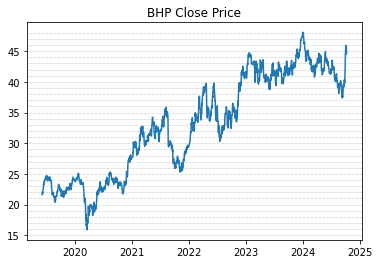

In [33]:
# TODO: recent plot - different intervals

plt.title(f'{TICKER} Close Price')
plt.plot(historical_prices[TICKER]['Close'])
# plot some horizontal lines at each dollar (dotted faint line)
for i in range(int(np.ceil(historical_prices[TICKER]['Close'].min())-1), int(np.floor(historical_prices[TICKER]['Close'].max()))+1):
    plt.axhline(y=i, color='gray', linestyle=':', linewidth=0.5)
plt.show()

In [34]:
# dividends
display(historical_prices[TICKER][historical_prices[TICKER]
                                  ['Dividends'] > 0][['Dividends']])

,Dividends
Date,
2019-09-05 00:00:00+10:00,1.137026
2020-03-05 00:00:00+11:00,0.994036
2020-09-03 00:00:00+10:00,0.754561
2021-03-04 00:00:00+11:00,1.311347
2021-09-02 00:00:00+10:00,2.715270
2022-02-24 00:00:00+11:00,2.080559
2022-09-01 00:00:00+10:00,2.551839
2023-03-09 00:00:00+11:00,1.363636
2023-09-07 00:00:00+10:00,1.250651


In [35]:
# stock splits
display(historical_prices[TICKER][historical_prices[TICKER]
        ['Stock Splits'] > 0][['Stock Splits']])

,Stock Splits
Date,


In [36]:
assert False

AssertionError: 

# Other Stats

In [ ]:
TICKER = 'NVX'

In [ ]:
object = yf.Ticker(f'{TICKER}.AX')

In [ ]:
balance_sheet_row = [
    'Total Debt',  # total debt
    'Stockholders Equity',  # total equity & book value
    'Share Issued',  # n shares
]
balance_sheet = object.balance_sheet.loc[balance_sheet_row]

In [ ]:
cashflow_row = [
    'Free Cash Flow',  # cashflow
    'End Cash Position'  # cash
]

cashflows = object.cashflow.loc[cashflow_row]

In [ ]:
financial_row = [
    'EBIT',
    'Gross Profit',  # profit
    'Total Revenue'  # revenue
]

financials = object.financials.loc[financial_row]

In [ ]:
stock_fundementals = pd.concat([balance_sheet, cashflows, financials]).T
# sort the rows by index
stock_fundementals = stock_fundementals.sort_index()

In [ ]:
stock_fundementals['EPS'] = stock_fundementals['EBIT'] / \
    stock_fundementals['Share Issued']
stock_fundementals['D/E'] = stock_fundementals['Total Debt'] / \
    stock_fundementals['Stockholders Equity']
stock_fundementals['Book Value Per Share'] = stock_fundementals['Stockholders Equity'] / \
    stock_fundementals['Share Issued']

In [ ]:
# if whole row is NaN, drop it
stock_fundementals = stock_fundementals.dropna(how='all')

In [ ]:
stock_fundementals

,Total Debt,Stockholders Equity,Share Issued,Free Cash Flow,End Cash Position,EBIT,Gross Profit,Total Revenue,EPS,D/E,Book Value Per Share
2020-06-30,NaN,NaN,NaN,-7426208.0,26690276.0,-11072623.0,2016403.0,2851035.0,NaN,NaN,NaN
2021-06-30,10356322.0,138449834.0,404601384.0,-25664712.0,102601252.0,-13305925.0,3083075.0,3893739.0,-0.032887,0.074802,0.342188
2022-06-30,42309006.0,251133478.0,485951369.0,-113019442.0,142737362.0,-50391738.0,4376530.0,6101155.0,-0.103697,0.168472,0.516787
2022-12-31,41341840.0,226056269.0,486774622.0,NaN,NaN,NaN,NaN,NaN,NaN,0.182883,0.464396
2023-12-31,69387750.0,183936275.0,488733461.0,-55424219.0,78713885.0,-43602661.0,5237259.0,8054528.0,-0.089216,0.377238,0.376353


In [ ]:
# gross margin = gross profit / total revenue
# net margin = ebit / total revenue

# interest coverage: ebit / interest expense (or finance cost)

# TODO:



Need to calculate:
- multiples
    - needs a price
- percentage change

- (after confirm all our multiples) want to get average of peers, weighted. 

- peer weighted first part growth.

Challenges:
- different dates of report (june 30th or dec 31st) (challenge for calculating percentage growth)

- nans occuring in different places (challenge for calculating percentage growth)

- engineering problem: 
    - getting stock data takes quite a long time... (first part)
    

Presentation:
- present it in a pdf report